# Classroom 6 - Training a Named Entity Recognition Model with a LSTM

The classroom today is primarily geared towards preparing you for Assignment 4 which you'll be working on after today. The notebook is split into three main parts to get you thinking. You should work through these sections in groups together in class. 

If you have any questions or things you don't understand, make a note of them so you can remember to ask - or, even better, post them to Slack!

If you get through everything here, make a start on the assignment. If you don't, dont' worry about it - but I suggest you finish all of the exercises here before starting the assignment.

## 1. A very short intro to NER
Named entity recognition (NER) also known as named entity extraction, and entity identification is the task of tagging an entity is the task of extracting which seeks to extract named entities from unstructured text into predefined categories such as names, medical codes, quantities or similar.

The most common variant is the [CoNLL-20003](https://www.clips.uantwerpen.be/conll2003/ner/) format which uses the categories, person (PER), organization (ORG) location (LOC) and miscellaneous (MISC), which for example denote cases such nationalies. For example:

*Hello my name is $Ross_{PER}$ I live in $Aarhus_{LOC}$ and work at $AU_{ORG}$.*

For example, let's see how this works with ```spaCy```. NB: you might need to remember to install a ```spaCy``` model:

```python -m spacy download en_core_web_sm```

In [2]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Hello my name is Ross. I live in Denmark and work at Aarhus University, I am Scottish and today is Friday 28th.")

In [32]:
import matplotlib.pyplot as plt

In [3]:
from spacy import displacy
displacy.render(doc, style="ent")

## Tagging standards
There exist different tag standards for NER. The most used one is the BIO-format which frames the task as token classification denoting inside, outside and beginning of a token. 

Words marked with *O* are not a named entity. Words with NER tags which start with *B-\** indicate the start of a multiword entity (i.e. *B-ORG* for the *Aarhus* in *Aarhus University*), while *I-\** indicate the continuation of a token (e.g. University).

    B = Beginning
    I = Inside
    O = Outside

<details>
<summary>Q: What other formats and standards are available? What kinds of entities do they make it possible to tag?</summary>
<br>
You can see more examples on the spaCy documentation for their [different models(https://spacy.io/models/en)
</details>


In [5]:
for t in doc:
    if t.ent_type:
        print(t, f"{t.ent_iob_}-{t.ent_type_}")
    else:
        print(t, t.ent_iob_)

Hello O
my O
name O
is O
Ross B-PERSON
. O
I O
live O
in O
Denmark B-GPE
and O
work O
at O
Aarhus B-ORG
University I-ORG
, O
I O
am O
Scottish B-NORP
and O
today B-DATE
is O
Friday B-DATE
28th I-DATE
. O


# For the Q:
https://towardsdatascience.com/named-entity-recognition-ner-using-spacy-nlp-part-4-28da2ece57c6 this link shows the other options

In [ ]:
?displacy

### Some challenges with NER
While NER is currently framed as above this formulating does contain some limitations. 

For instance the entity Aarhus University really refers to both the location Aarhus, the University within Aarhus, thus nested NER (N-NER) argues that it would be more correct to tag it in a nested fashion as \[\[$Aarhus_{LOC}$\] $University$\]$_{ORG}$ (Plank, 2020). 

Other task also include named entity linking. Which is the task of linking an entity to e.g. a wikipedia entry, thus you have to both know that it is indeed an entity and which entity it is (if it is indeed a defined entity).

In this assignment, we'll be using Bi-LSTMs to train an NER model on a predifined data set which uses IOB tags of the kind we outlined above.

## 2. Training in batches

When you trained your document classifier for the last assignment, you probably noticed that the neural network was quite brittle. Small changes in the hyperparameters could cause massive changes in performance. Likewise, you probably noticed that they tend to substantially overfit the training data and underperform on the validation and test data.

One way we can get around this is by processing the data in smaller chunks known as *batches*. 

<details>
<summary>Q: Why might it be a good idea to train on batches, rather than the whole dataset?</summary>
<br>
These batches are usually small (something like 32 instances at a time) but they have couple of important effects on training:

- Batches can be processed in parallel, rather the sequentially. This can result in substantial speed up from computational perspective
- Similarly, smaller batch sizes make it easier to fit training data into memory
- Lastly,  smaller batch sizes are noisy, meaning that they have a regularizing effect and thus lead to less overfitting.

In this assignment, we're going to be using batches of data to train our NER model. To do that, we first have to prepare our batches for training. You can read more about batching in [this blog post](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/).

</details>



# One reason might be because of speed. The algorithm has to store too much error values when not splitting it up into batches

In [5]:
# this allows us to look one step up in the directory
# for importing custom modules from src
import sys
sys.path.append("..")
from src.util import batch

# numpy and pytorch
import numpy as np
import torch

# loading data and embeddings
from datasets import load_dataset
import gensim.downloader as api

In [6]:
from src.LSTM import RNN
from src.embedding import gensim_to_torch_embedding


We can download the datset using the ```load_dataset()``` function we've already seen. Here we take only the training data.

When you've downloaded the dataset, you're welcome to save a local copy so that we don't need to constantly download it again everytime the code runs.

Q: What do the ```train.features``` values refer to?

Q: what do the train.features values refer to?

We have the following features in the train df: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']

id refers 


In [7]:
# DATASET
dataset = load_dataset("conllpp")
train = dataset["train"]

# inspect the dataset
train["tokens"][:1]
train["ner_tags"][:1]

# get number of classes
num_classes = train.features["ner_tags"].feature.num_classes

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conllpp downloaded and prepared to /home/coder/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# inspect the dataset
train["tokens"][:4]
# train["ner_tags"][:1]

# # # get number of classes
# num_classes = train.features["ner_tags"].feature.num_classes

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['Peter', 'Blackburn'],
 ['BRUSSELS', '1996-08-22'],
 ['The',
  'European',
  'Commission',
  'said',
  'on',
  'Thursday',
  'it',
  'disagreed',
  'with',
  'German',
  'advice',
  'to',
  'consumers',
  'to',
  'shun',
  'British',
  'lamb',
  'until',
  'scientists',
  'determine',
  'whether',
  'mad',
  'cow',
  'disease',
  'can',
  'be',
  'transmitted',
  'to',
  'sheep',
  '.']]

In [ ]:
train.features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

We then use ```gensim``` to get some pretrained word embeddings for the input layer to the model. 

In this example, we're going to use a GloVe model pretrained on Wikipedia, with 50 dimensions.

I've provided a helper function to take the ```gensim``` embeddings and prepare them for ```pytorch```.

In [8]:
# CONVERTING EMBEDDINGS
model = api.load("glove-wiki-gigaword-50") # loading an unsupervised learning algorithm for obtaining vector representations of words

# convert gensim word embedding to torch word embedding
embedding_layer, vocab = gensim_to_torch_embedding(model)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [37]:
?gensim_to_torch_embedding

Signature: gensim_to_torch_embedding(gensim_wv)
Docstring:
- Add type hints on input and output
- add function description
- understand the pad and unk embeddings, add an argument which makes these optional. 
    E.g. add_padding = True and add_unknown = True
File:      /work/NLP-AU/src/embedding.py
Type:      function


### Preparing a batch

The first thing we want to do is to shuffle our dataset before training. 

Why might it be a good idea to shuffle the data?

Shuffling training data, both before training and between epochs, helps prevent model overfitting by ensuring that batches are more representative of the entire dataset (in batch gradient descent)

In [9]:
# shuffle dataset
shuffled_train = dataset["train"].shuffle(seed=1)

Next, we want to bundle the shuffled training data into smaller batches of predefined size. I've written a small utility function here to help. 

<details>
<summary>Q: Can you explain how the ```batch()``` function works?</summary>
<br>
 Hint: Check out [this link](https://realpython.com/introduction-to-python-generators/).
</details>



#The batch function 
Creates batches from an iterable dataset and with a specified bach size. 

First, it returns an iterator of the data set specified. An iterator is an object that contains a countable number of values.
Then it returns an iterable of tuples of size equal to batch_sizd
The batch size refers to, not number of batches, but to the size of each batch. number of batches depends on batch size

In [10]:
batch_size = 32
batches_tokens = batch(shuffled_train["tokens"], batch_size)
batches_tags = batch(shuffled_train["ner_tags"], batch_size)

Next, we want to use the ```tokens_to_idx()``` function below on our batches.

<details>
<summary>Q: What is this function doing? Why is it doing it?</summary>
<br>
We're making everything lowercase and adding a new, arbitrary token called <UNK> to the vocabulary. This <UNK> means "unknown" and is used to replace out-of-vocabulary tokens in the data - i.e. tokens that don't appear in the vocabulary of the pretrained word embeddings.
</details>


the function takes the input #tokens and vocab. vocab calls, from model specified aboce, key_to_index which is a dictionary of words and their given values. 

the .get method returns all that is inputted to it: returns the value of the item with the specified key.
the t.lower() returns strings where all cases are lower case.



In [11]:
def tokens_to_idx(tokens, vocab = model.key_to_index):
    """
    - Write documentation for this function including type hints for each argument and return statement
    - What does the .get method do?
    - Why lowercase?
    """
    return [vocab.get(t.lower(), vocab["UNK"]) for t in tokens]

In [ ]:
model.key_to_index

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

We'll check below that everything is working as expected as expected by testing it on a single batch.

In [12]:
# sample using only the first batch
batch_tokens = next(batches_tokens)
batch_tags = next(batches_tags)
batch_tok_idx = [tokens_to_idx(sent) for sent in batch_tokens]

In [13]:
# batch_tok_idx
batch_tokens

(['shares', 'outstanding'],
 ['Oldham', '22', '9', '1', '12', '473', '681', '19'],
 ['Goldman',
  'Sachs',
  '&',
  'Co',
  'Wertpapier',
  'GmbH',
  'has',
  'issued',
  'a',
  'total',
  'of',
  'five',
  'million',
  'American-style',
  'call',
  'warrants',
  ',',
  'on',
  'Continental',
  'AG',
  ',',
  'lead',
  'manager',
  'Goldman',
  'Sachs',
  '&',
  'Co',
  'said',
  '.'],
 ['CINCINNATI', '64', '63', '.504', '3', '1/2'],
 ['MELBOURNE', '1996-08-23'],
 ['--',
  'FLNC',
  'Corsican',
  'nationalist',
  'movement',
  'announces',
  'end',
  'of',
  'truce',
  'after',
  'last',
  'night',
  "'s",
  'attacks',
  '.'],
 ['4-6', '7-6', '(', '7-4', ')'],
 ['Dealers',
  'said',
  'that',
  'the',
  'volume',
  'of',
  'longer-term',
  'government',
  'paper',
  'declined',
  'due',
  'to',
  'market',
  'nervousness',
  '.'],
 ['MONTREAL', 'AT', 'SAN', 'FRANCISCO'],
 ['"',
  'I',
  'would',
  'love',
  'to',
  'speak',
  'about',
  'everything',
  ',',
  '"',
  'said',
  'Simpson'

In [ ]:
# the next() function Return the next item from the iterator.

Docstring:
next(iterator[, default])

Return the next item from the iterator. If default is given and the iterator
is exhausted, it is returned instead of raising StopIteration.
Type:      builtin_function_or_method


As with document classification, our model needs to take input sequences of a fixed length. To get around this we do a couple of different steps.

- Find the length of the longest sequence in the batch
- Pad shorter sequences to the max length using an arbitrary token like <PAD>
- Give the <PAD> token a new label ```-1``` to differentiate it from the other labels

In [14]:
# compute length of longest sentence in batch
batch_max_len = max([len(s) for s in batch_tok_idx])

Q: Can you figure out the logic of what is happening in the next two cells?

In [16]:
batch_input = vocab["PAD"] * np.ones((batch_size, batch_max_len))
batch_labels = -1 * np.ones((batch_size, batch_max_len))

In [17]:
# copy the data to the numpy array
for i in range(batch_size):
    tok_idx = batch_tok_idx[i]
    tags = batch_tags[i]
    size = len(tok_idx)

    batch_input[i][:size] = tok_idx
    batch_labels[i][:size] = tags

The last step is to conver the arrays into ```pytorch``` tensors, ready for the NN model.

In [18]:
# since all data are indices, we convert them to torch LongTensors (integers)
batch_input, batch_labels = torch.LongTensor(batch_input), torch.LongTensor(
    batch_labels
)

With our data now batched and processed, we want to run it through our RNN the same way as when we trained a clasifier. Note that this cell is incomplete and won't yet run; that's part of the assignment!

Q: Why is ```output_dim = num_classes + 1```?

In [19]:
?RNN

Init signature:
RNN(
    output_dim: int,
    embedding_layer: torch.nn.modules.sparse.Embedding,
    hidden_dim_size: int,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: 

[INFO:] Training classifier...
epoch: 10, loss = 0.8666
epoch: 20, loss = 0.7439
epoch: 30, loss = 0.6424
epoch: 40, loss = 0.6036
epoch: 50, loss = 0.5650
epoch: 60, loss = 0.5144
epoch: 70, loss = 0.4540
epoch: 80, loss = 0.3981
epoch: 90, loss = 0.3403
epoch: 100, loss = 0.2819
[INFO:] Finished traning!


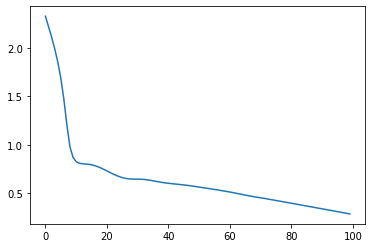

In [33]:
# CREATE MODEL
model = RNN(
    embedding_layer=embedding_layer, output_dim=num_classes + 1, hidden_dim_size=256
)


#loss_fn takes a prediction tensor and a target tensor as arguments
# it returns the average loss over all observations in the batch
# the outputs here are our prediction tensors



# define loss and optimizer
optimizer = torch.optim.AdamW(model.parameters())


# train
epochs = 100
print("[INFO:] Training classifier...")
loss_history = []
for epoch in range(epochs):
    # forward
    X = batch_input
    y = model(X)

    # backward
    loss = model.loss_fn(outputs=y, labels=batch_labels)
    loss_history.append(loss)

    # backpropagation
    loss.backward()
    # take step, reset
    optimizer.step()
    optimizer.zero_grad()

    # some print to see that it is running
    if (epoch + 1) % 10 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f}")

print("[INFO:] Finished traning!")

loss_H = [val.item() for val in loss_history]
fig, ax = plt.subplots()
ax.plot(loss_H)



In [38]:
?RNN

Init signature:
RNN(
    output_dim: int,
    embedding_layer: torch.nn.modules.sparse.Embedding,
    hidden_dim_size: int,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: 

In [28]:
type(X)

torch.Tensor

## 3. Creating an LSTM with ```pytorch```

In the file [LSTM.py](../src/LSTM.py), I've aready created an LSTM for you using ```pytorch```. Take some time to read through the code and make sure you understand how it's built up.

Some questions for you to discuss in groups:

- How is an LSTM layer created using ```pytorch```? How does the code compare to the classifier code you wrote last week?
- What's going on with that weird bit that says ```@staticmethod```?
  - [This might help](https://realpython.com/instance-class-and-static-methods-demystified/).
- On the forward pass, we use ```log_softmax()``` to make output predictions. What is this, and how does it relate to the output from the sigmoid function that we used in the document classification?
- How would we make this LSTM model *bidirectional* - i.e. make it a Bi-LSTM? 
  - Hint: Check the documentation for the LSTM layer on the ```pytorch``` website.